## Attack Detection

In [1]:
import pandas as pd
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix

from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,ExtraTreesClassifier 
from sklearn import preprocessing
import itertools

In [2]:
df = pd.read_excel("SNMPdataset.xlsx")
df.drop(df.index[0],inplace=True)
df.head(5)


,SNMP Parameters,icmp_AddrMaskReps,icmp_InAddrMasks,icmp_InDestUnreachs,icmp_InEchosReps,icmp_InEchos,icmp_InErrors,icmp_InMsgs,icmp_InParmProbs,icmp_InRedirects,...,tcp_PassiveOpens,tcp_RetransSegs,tcp_RtoAlgorithm,tcp_RtoMax,tcp_RtoMin,udp_InDatagrams,udp_InErrors,udp_NoPorts,udp_OutDatagrams,ClassLabel
1,Mon Jul 31 15:49:58 UTC 2017 Counter32 value,0,0,0,16,0,0,17,0,0,...,1,0,1,120000,200,148,0,1,149,Normal
2,Mon Jul 31 15:50:31 UTC 2017 Counter32 value,0,0,0,111,0,0,112,0,0,...,2,0,1,120000,200,445,0,1,446,Normal
3,Mon Jul 31 15:51:10 UTC 2017 Counter32 value,0,0,0,229,0,0,230,0,0,...,2,0,1,120000,200,741,0,1,742,Normal
4,Mon Jul 31 15:51:44 UTC 2017 Counter32 value,0,0,0,0,0,0,332,0,0,...,2,0,1,120000,200,1037,0,1,1038,Normal
5,Mon Jul 31 15:52:24 UTC 2017 Counter32 value,0,0,0,442,0,0,443,0,0,...,2,0,1,120000,200,1333,0,1,1334,Normal


In [3]:
df['ClassLabel'].unique()

array(['Normal', 'Attack'], dtype=object)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421 entries, 1 to 2421
Data columns (total 66 columns):
SNMP Parameters           2421 non-null object
icmp_AddrMaskReps         2421 non-null object
icmp_InAddrMasks          2421 non-null object
icmp_InDestUnreachs       2421 non-null object
icmp_InEchosReps          2421 non-null object
icmp_InEchos              2421 non-null object
icmp_InErrors             2421 non-null object
icmp_InMsgs               2421 non-null object
icmp_InParmProbs          2421 non-null object
icmp_InRedirects          2421 non-null object
icmp_InSrcQuenchs         2421 non-null object
icmp_InTimeExcds          2421 non-null object
icmp_InTimestampReps      2421 non-null object
icmp_InTimestamps         2421 non-null object
icmp_OutAddrMaskReps      2421 non-null object
icmp_OutAddrMasks         2421 non-null object
icmp_OutDestUnreachs      2421 non-null object
icmp_OutEchoReps          2421 non-null object
icmp_OutEchos             2421 non-null object


In [5]:
df.describe()

,SNMP Parameters,icmp_AddrMaskReps,icmp_InAddrMasks,icmp_InDestUnreachs,icmp_InEchosReps,icmp_InEchos,icmp_InErrors,icmp_InMsgs,icmp_InParmProbs,icmp_InRedirects,...,tcp_PassiveOpens,tcp_RetransSegs,tcp_RtoAlgorithm,tcp_RtoMax,tcp_RtoMin,udp_InDatagrams,udp_InErrors,udp_NoPorts,udp_OutDatagrams,ClassLabel
count,2421,2421,2421,2421,2421,2421,2421,2421,2421,2421,...,2421,2421,2421,2421,2421,2421,2421,2421,2421,2421
unique,2421,1,1,1,416,1,22,449,1,1,...,6,58,1,1,1,1391,1,505,1418,2
top,Sun Mar 26 10:09:30 UTC 2017 Counter32 value,0,0,0,0,0,0,1,0,0,...,2,0,1,120000,200,46917,0,1,15838,Normal
freq,1,2421,2421,2421,1997,2421,2182,1760,2421,2421,...,1929,1001,2421,2421,2421,5,2421,1316,6,1250


In [6]:
'''df1 = df.iloc[:,:28]
sns.pairplot(df.dropna(),vars=df1.columns,hue= 'ClassLabel')'''

"df1 = df.iloc[:,:28]\nsns.pairplot(df.dropna(),vars=df1.columns,hue= 'ClassLabel')"

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [8]:
def remove_similar(df):
    for col in df.columns:
        m=pd.unique(df[col]).tolist()
        if (len(m)==1):
            del df[col]
        else:
            pass
    return df

In [9]:
df= df.replace(0,np.nan)
df=df.dropna(how='all',axis=1)
df=df.replace(np.nan,0)
if "SNMP Parameters" in df.columns:
    del df["SNMP Parameters"]
col=['icmp_InEchosReps', 'icmp_InErrors', 'icmp_InMsgs', 'icmp_InTimeExcds']
df1=df[col].astype('float')
df = remove_similar(df)
df.head()

,icmp_InEchosReps,icmp_InErrors,icmp_InMsgs,icmp_InTimeExcds,icmp_InTimestamps,icmp_OutEchoReps,icmp_OutErrors,icmp_OutTimeExcds,icmp_OutTimestamps,ip_FragCreates,...,tcp_EstabResets,tcp_InSegs,tcp_OutRsts,tcp_OutSegs,tcp_PassiveOpens,tcp_RetransSegs,udp_InDatagrams,udp_NoPorts,udp_OutDatagrams,ClassLabel
1,16.0,0.0,17,1.0,0.0,0.0,17.0,1.0,16.0,0.0,...,0.0,178,0.0,213,1,0.0,148,1,149,Normal
2,111.0,0.0,112,1.0,0.0,0.0,112.0,1.0,127.0,0.0,...,0.0,198,0.0,243,2,0.0,445,1,446,Normal
3,229.0,0.0,230,1.0,0.0,0.0,230.0,1.0,229.0,0.0,...,0.0,255,0.0,282,2,0.0,741,1,742,Normal
4,0.0,0.0,332,1.0,0.0,0.0,347.0,1.0,346.0,0.0,...,0.0,261,0.0,287,2,0.0,1037,1,1038,Normal
5,442.0,0.0,443,1.0,0.0,0.0,443.0,1.0,442.0,0.0,...,0.0,273,0.0,296,2,0.0,1333,1,1334,Normal


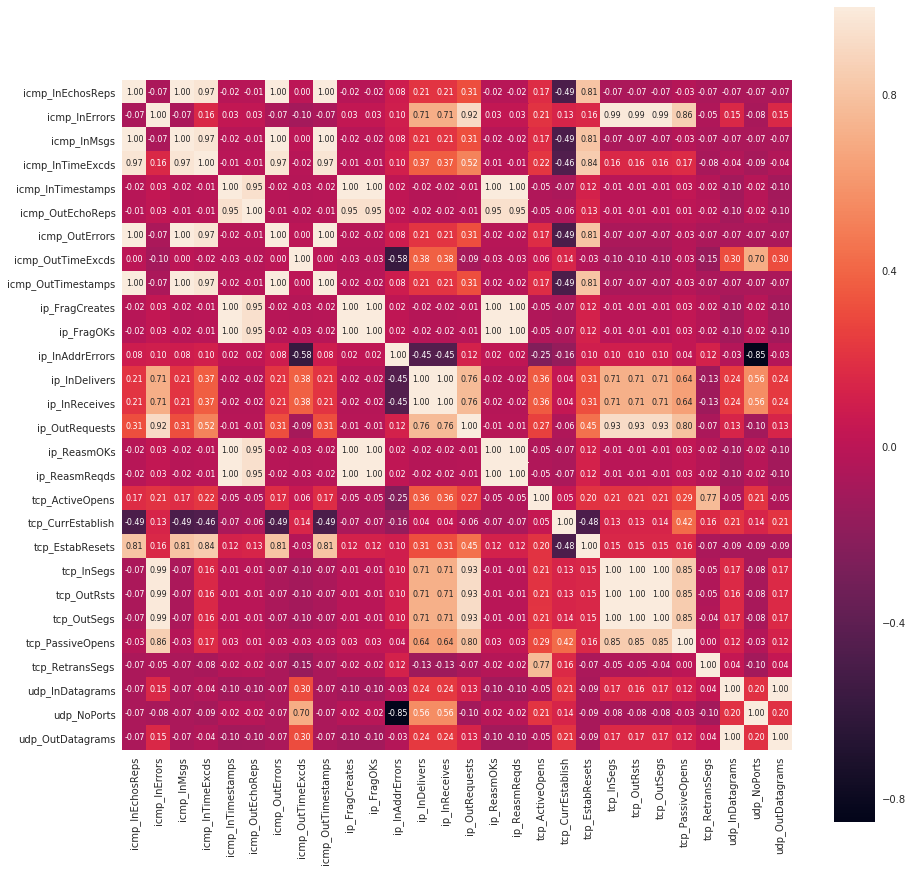

In [10]:
df1= df.iloc[:,:28]
cm = np.corrcoef(df1.values.T)
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize':(15,15)})
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 8},yticklabels=df1.columns,xticklabels=df1.columns)

In [11]:
from sklearn.cross_validation import train_test_split
y = df['ClassLabel']
X = df.iloc[:,:28]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
y_train=np.array(y_train).reshape(-1,1)

/home/witcher/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
def models(X_train,X_test,y_train,y_test):
    names = ["K Nearest Neighbors", "XGBoost","Decision Tree", "Random Forest","ExtraTreesClassifier","SVM"]
    classifiers = [KNeighborsClassifier(20),
                   xgb.XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=100),
                   DecisionTreeClassifier(max_depth=2),
                   RandomForestClassifier(max_depth=5, n_estimators=100,max_features=7),
                   ExtraTreesClassifier(max_depth=5,n_estimators=100,max_features=7),
                   svm.SVC(kernel='rbf')]
    for name, clf in zip(names, classifiers):
        fig_size = plt.rcParams["figure.figsize"]
        # Prints: [8.0, 6.0]
        #print("Current size:", fig_size)
 
        # Set figure width to 12 and height to 9
        fig_size[0] = 5
        fig_size[1] = 5
        plt.rcParams["figure.figsize"] = fig_size
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        y_pred=clf.predict(X_test)
        #confusion_matrix = ConfusionMatrix(y_test, y_pred)
        #print("Confusion matrix:\n%s" % confusion_matrix)
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test, y_pred)
        np.set_printoptions(precision=2)
        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=df['ClassLabel'].unique(),
                              title='Confusion matrix, without normalization')
        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=df['ClassLabel'].unique(), normalize=True,
                              title='Normalized confusion matrix')
        plt.show()
    
        print(name+' Score:',score)
        prediction1 = clf.predict(X_test)
        np.set_printoptions(precision=2)
    return 1


/home/witcher/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Confusion matrix, without normalization
Normalized confusion matrix


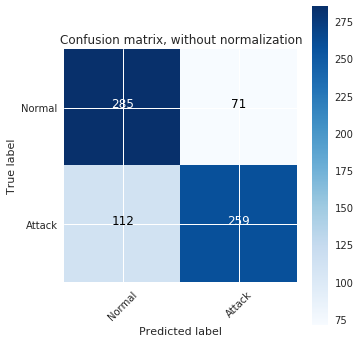

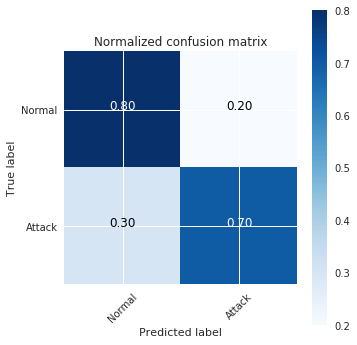

K Nearest Neighbors Score: 0.7482806052269602
Confusion matrix, without normalization


/home/witcher/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/witcher/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/witcher/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/witcher/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, 

Normalized confusion matrix


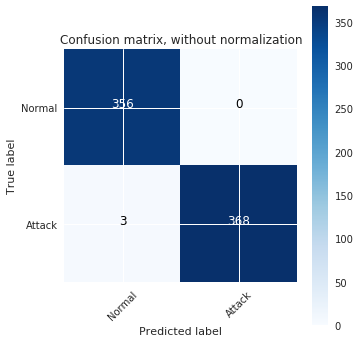

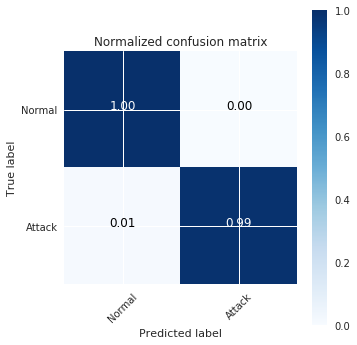

XGBoost Score: 0.9958734525447043
Confusion matrix, without normalization
Normalized confusion matrix


/home/witcher/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


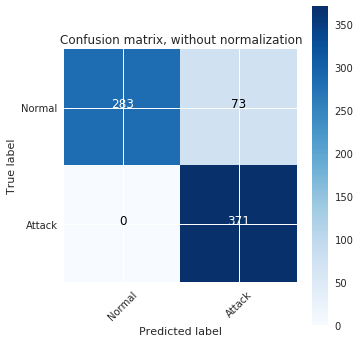

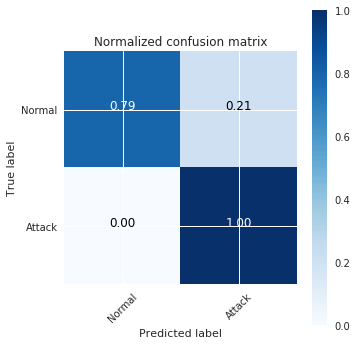

Decision Tree Score: 0.8995873452544704
Confusion matrix, without normalization


/home/witcher/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix


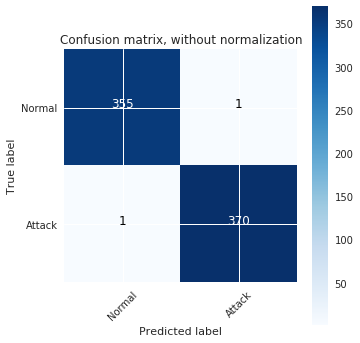

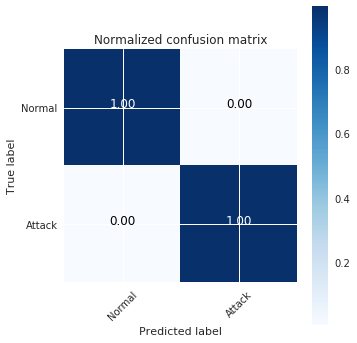

Random Forest Score: 0.9972489683631361
Confusion matrix, without normalization


/home/witcher/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix


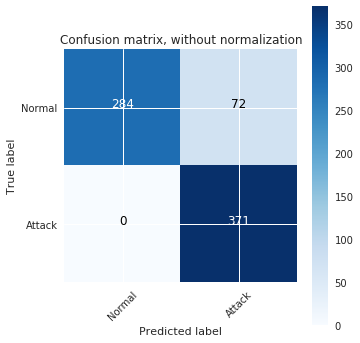

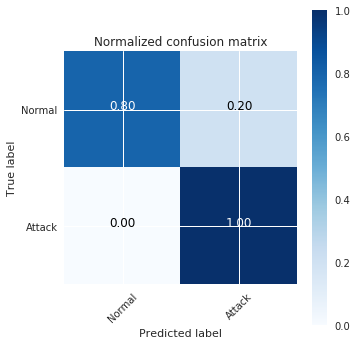

ExtraTreesClassifier Score: 0.9009628610729024


/home/witcher/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion matrix, without normalization
Normalized confusion matrix


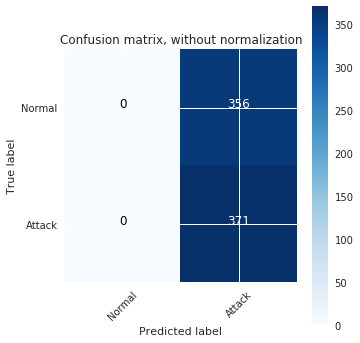

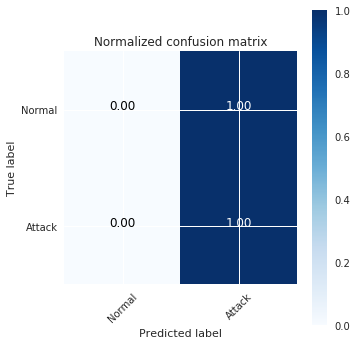

SVM Score: 0.5103163686382394


1

In [24]:
models(X_train,X_test,y_train,y_test)

In [ ]:
writer = pd.ExcelWriter('output.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

In [ ]:
!ls


